<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_16_CNNs_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the Libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# To get summaries of the models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Feature Map Activators

## Re-Create the Gaussian Dataset

In [2]:
# Number of images and image size
nPerClass = 1000
imgsize = 91

x = np.linspace(-4,4,imgsize)
X,Y = np.meshgrid(x,x)

# The two widths of the Gaussian: class1 and class2 in arbitrary units
widths = [1.8, 2.4]

# Initialize tensots containing images and labels
images = torch.zeros(2*nPerClass ,1 ,imgsize, imgsize)
labels = torch.zeros(2*nPerClass)

# Create the images
for i in range(2*nPerClass):

    # Create Gaussians with random centers
    ro = 2*np.random.randn(2) # ro: random offset
    G  = np.exp(-( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

    # Add Noise
    G = G + np.random.randn(imgsize, imgsize)/5

    # Add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1, imgsize, imgsize)
    labels[i] = i%2

# Make labels as 1d matrix
labels = labels[:,None]

print(images.shape)

torch.Size([2000, 1, 91, 91])


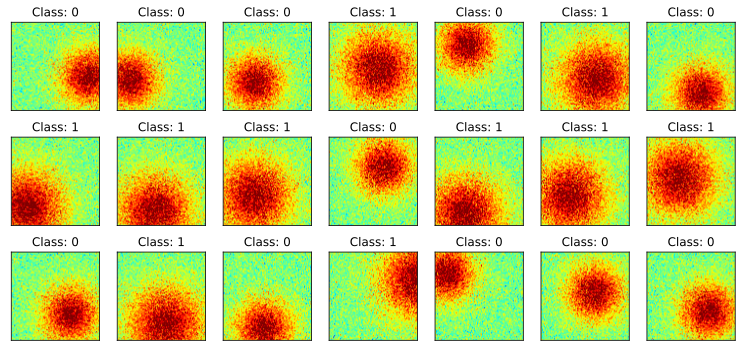

In [3]:
fig,axs = plt.subplots(3,7,figsize=(13,6))

for i,ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(2*nPerClass)
    G = np.squeeze(images[whichpic,:,:])
    ax.imshow(G, vmin=-1, vmax=1, cmap="jet")
    ax.set_title(f"Class: {int(labels[whichpic].item())}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Create the DataLoaders

In [4]:
# Split the data into train and test set
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into Pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Translate into DataLoader object
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
# Check the sizes
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)
print(test_loader.dataset.tensors[0].shape)
print(test_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])
torch.Size([200, 1, 91, 91])
torch.Size([200, 1])


## Model Architecture

In [10]:
def makeTheNet():

    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            # Define the convolution layers
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            # size: np.floor((91+2*1-3)/1) +1 = 91
            # post-pooling: 91/2 = 45

            self.conv2 = nn.Conv2d(6,4, 3, padding=1)
            # size: np.floor((45+2*1-3)/1) +1 = 45
            # post-pooling: 45/2 = 22

            # Fully-connected layer
            self.fc1 = nn.Linear(22*22*4,50)

            # Output layer
            self.fc2 = nn.Linear(50,1)

        # Forward Pass
        def forward(self,x):

            # First conv-pool set
            conv1act = F.relu(self.conv1(x))
            x = F.avg_pool2d(conv1act,(2,2))

            # Second conv-pool set
            conv2act = F.relu(self.conv2(x))
            x = F.avg_pool2d(conv2act,(2,2))

            # The ANN part
            x = x.reshape(x.shape[0],-1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)

            return x, conv1act, conv2act

    # Create the model instance
    net = GaussNet()

    # define the loss function
    lossfun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [11]:
# Test the model with one batch to make sure it works
net, lossfun, optimizer = makeTheNet()
X,y = next(iter(train_loader))

yHat, featmap1, featmap2 = net(X)

loss = lossfun(yHat,y)
print(loss)

tensor(0.6960, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [12]:
# check the output sizes
print('Predicted category:')
print(yHat.shape)
print('\nFeature map after conv1')
print(featmap1.shape)
print('\nFeature map after conv2')
print(featmap2.shape)

Predicted category:
torch.Size([32, 1])

Feature map after conv1
torch.Size([32, 6, 91, 91])

Feature map after conv2
torch.Size([32, 4, 45, 45])


In [13]:
# Get a summary of the model
summary(net,(1, imgsize, imgsize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
            Linear-3                   [-1, 50]          96,850
            Linear-4                    [-1, 1]              51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84
----------------------------------------------------------------


In [18]:
# Create a function to train the model
def function2trainThemodel():

    # Define the number of epochs
    numepochs = 10

    # Create a new model instance
    net, lossfun, optimizer = makeTheNet()

    # initialize the losses
    losses = np.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # Loop over the batches
        net.train()

        batchAcc = []
        batchLoss = []
        for X,y in train_loader:

            # Forward Pass
            yHat = net(X)[0]
            loss = lossfun(yHat,y)

            # BackPropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss of a particular batch
            batchLoss.append(loss.item())

            # Compute the accuracy of the batch
            batchAcc.append(100*torch.mean(((yHat>0) ==y).float()).item())
        # End of he batch loop

        # Get the values for training accuracy of a single epoch
        trainAcc.append(np.mean(batchAcc))

        # Train loss for single epoch
        losses[epochi,0] = np.mean(batchLoss)

        # Test Accuracy
        net.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)[0]

        # Test Accuracy
        testAcc.append(100*torch.mean(((yHat>0) ==y).float()).item())
        loss = lossfun(yHat,y)
        losses[epochi,1] = loss.item()

    # End the Epochs
    return trainAcc, testAcc, losses, net

In [19]:
# Train the whole model using the same function as above
trainAcc, testAcc, losses, net = function2trainThemodel()

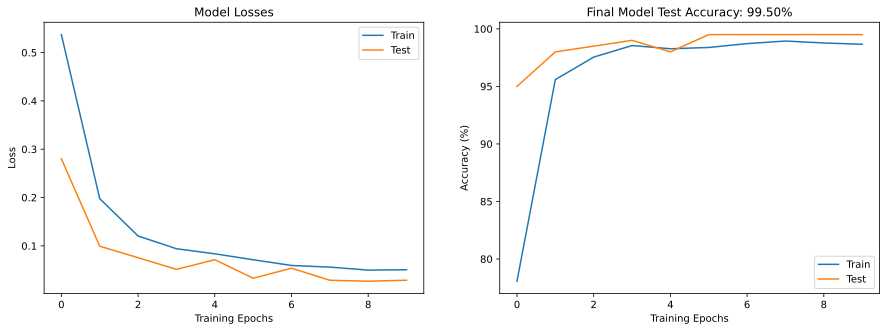

In [20]:
# Visualize it
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses)
ax[0].set_xlabel("Training Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(["Train", "Test"])
ax[0].set_title("Model Losses")

ax[1].plot(trainAcc, label="Train")
ax[1].plot(testAcc, label="Test")
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Final Model Test Accuracy: {:.2f}%".format(testAcc[-1]))
ax[1].legend()

plt.show()

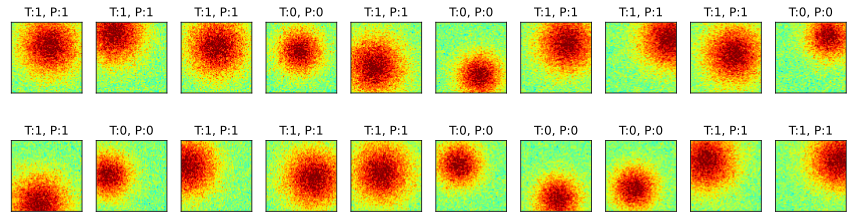

In [21]:
# visualize some images
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat,featmap1,featmap2 = net(X)

fig,axs = plt.subplots(2,10,figsize=(15,4))

for i,ax in enumerate(axs.flatten()):
    G = torch.squeeze( X[i,0,:,:] ).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    t = ( int(y[i].item()) , int(yHat[i].item()>.5) )
    ax.set_title('T:%s, P:%s'%t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Visualize Feature Maps

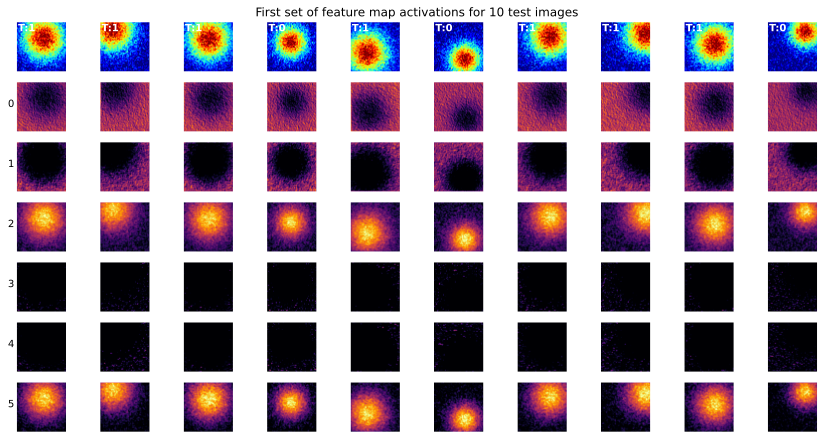

In [22]:
# Visualize Feature Maps
fig,axs = plt.subplots(7,10,figsize=(12,6))

for pici in range(10):

    # show the original picture
    img = X[pici,0,:,:].detach()
    axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
    axs[0,pici].axis('off')
    axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

    for feati in range(6):
        # extract the feature map from this image
        img = featmap1[pici,feati,:,:].detach()
        axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()
# First row shows actual data
# Other rows are feature maps (6 feature maps per image because we have 6 kernels)

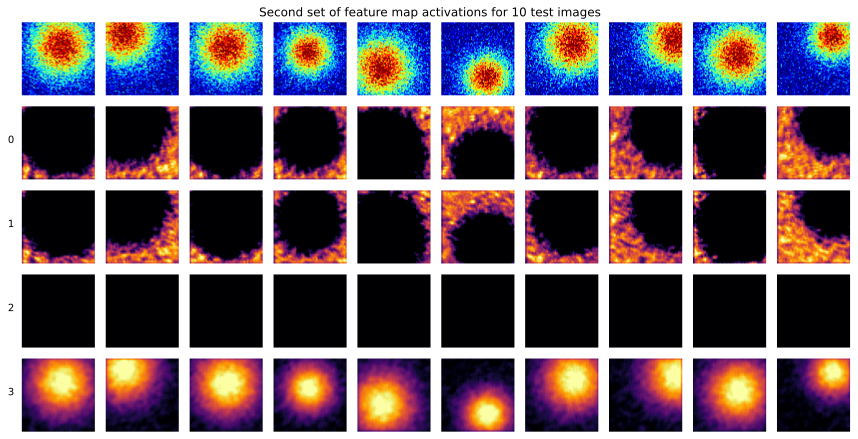

In [23]:
# Feature 2 maps
fig,axs = plt.subplots(5,10,figsize=(12,6))

for pici in range(10):

    # show the original picture
    img = X[pici,0,:,:].detach()
    axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
    axs[0,pici].axis('off')

    for feati in range(4):
        # extract the feature map from this image
        img = featmap2[pici,feati,:,:].detach()
        axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
        axs[feati+1,pici].axis('off')
        axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()
# Here we have 4 kernels

## Feature Layer Correlation

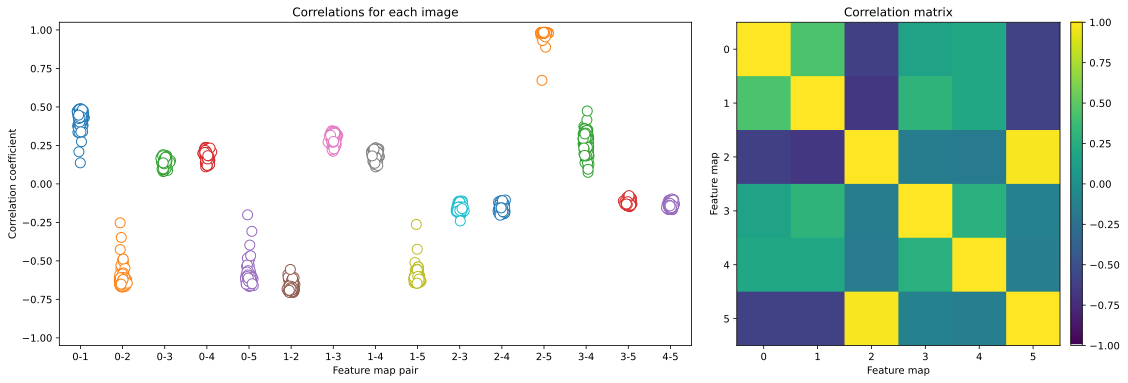

In [26]:
# correlations across the FIRST convolution layer
# convenient variables
nStim = featmap1.shape[0]
nMaps = featmap1.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps = featmap1[i,:,:,:].view(nMaps,-1).detach()

    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    Call += C

    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C,1))
    allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
    xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()

/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


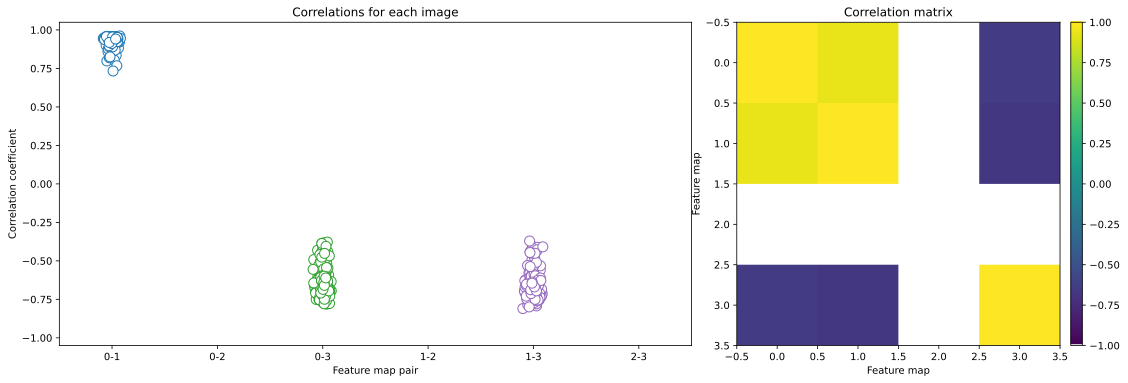

In [27]:
# convenient variables
nStim = featmap2.shape[0]
nMaps = featmap2.shape[1]
nCors = (nMaps*(nMaps-1))//2

# initialze the matrix of all correlation values
allrs = np.zeros((nStim,nCors))
Call  = np.zeros((nMaps,nMaps))

# loop over each stimulus
for i in range(nStim):

    # extract the vectorized feature maps from this image
    featmaps = featmap2[i,:,:,:].view(nMaps,-1).detach()

    # compute the correlation matrix
    C = np.corrcoef(featmaps)
    Call += C

    # extract the unique correlations from the matrix
    idx = np.nonzero(np.triu(C,1))
    allrs[i,:] = C[idx]


# define the x-axis labels
xlab = []*nCors
for i in range(nCors):
    xlab.append('%s-%s' %(idx[0][i],idx[1][i]))




# now visualize the correlations
fig = plt.figure(figsize=(16,5))
ax0 = fig.add_axes([.1,.1,.55,.9]) # [left, bottom, width, height]
ax1 = fig.add_axes([.68,.1,.3,.9])
cax = fig.add_axes([.98,.1,.01,.9])

for i in range(nCors):
    ax0.plot(i+np.random.randn(nStim)/30,allrs[:,i],'o',markerfacecolor='w',markersize=10)

# make the plot more interpretable
ax0.set_xlim([-.5,nCors-.5])
ax0.set_ylim([-1.05,1.05])
ax0.set_xticks(range(nCors))
ax0.set_xticklabels(xlab)
ax0.set_xlabel('Feature map pair')
ax0.set_ylabel('Correlation coefficient')
ax0.set_title('Correlations for each image')


# now show the average correlation matrix
h = ax1.imshow(Call/nStim,vmin=-1,vmax=1)
ax1.set_title('Correlation matrix')
ax1.set_xlabel('Feature map')
ax1.set_ylabel('Feature map')
# add a colorbar
fig.colorbar(h,cax=cax)

plt.show()